# 2.1 Building our first convolutional neural network

In this example, we follow and build on one of the tutorials on the [homepage of PyTorch]( https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), and we recommend this resource for delving deeper into the topic.

First, we load the libraries that we will need throughout this notebook.

<!--
1. <a href ="#Data">Data</a>
2. <a href ="#Architecture">Architecture</a>
3. <a href ="#Training">Training</a>
4. <a href ="#Testing">Testing</a>
5. <a href ="#Exercises">Exercises</a>
5. <a href ="#GPUs">GPUs</a>
-->

In [ ]:
# Needed for image handling
import torch
import torchvision
import torchvision.transforms as transforms
# Needed to build CNN
import torch.nn as nn
import torch.optim as optim
# Plotting tools
import matplotlib.pyplot as plt
import numpy as np
import time

## Data

In this notebook, we will work with the CIFAR10 dataset, containing thousands of images with 10 different labels (plane, car, bird, cat, deer, dog, frog, horse, ship and truck). Each picture has three channels (RGB) and is 32x32 pixels. Here, we separately load the test and training data, constructing batches with 32 images each.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Let's have a look at one of the pictures in the data set.

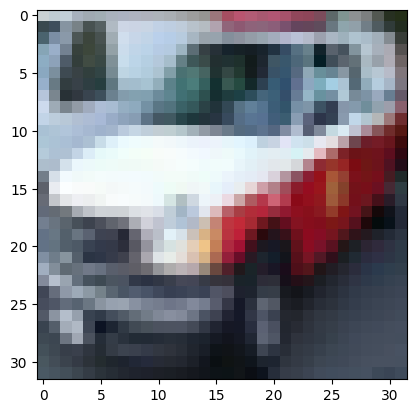

In [ ]:
plt.imshow(trainset.data[60])
plt.show()

It's clearly a low-resolution picture of a car. The labels in the data are simply the categories 0-9. Let's write labels that are easier for huma's to relate to.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Architecture

To create a convolutional neural network (CNN), we create a new class, here called CNN. We then initialise the class, inheriting from the parent class (here nn.Module) and defining the necessary components of our architecture. Having initialised the class, we put the components together to define how a forward pass will be executed.

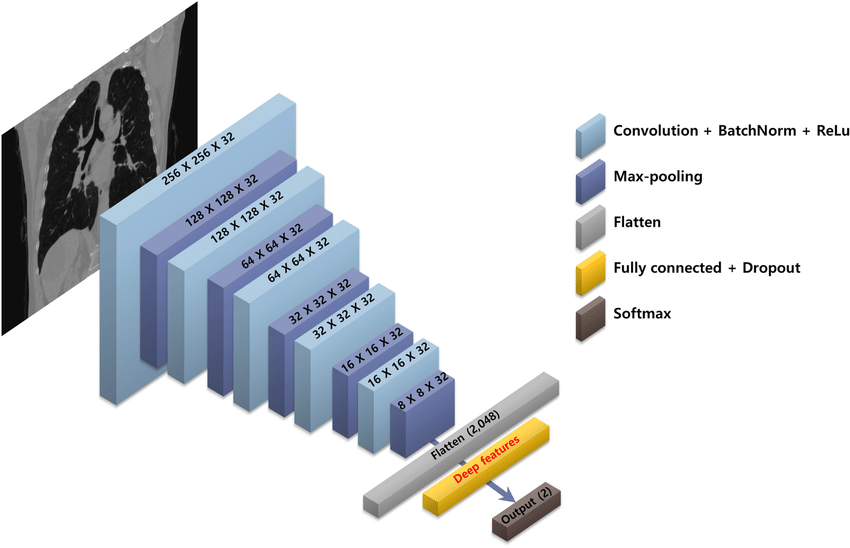

In [ ]:
# How many output channels do we want from the first convolutional layer?

output_channels_1 = 6

class CNN(nn.Module):
    def __init__(self):
        super().__init__() # Inherit from parent class
        # Define layers
        # First we have a convolutional layer with 3 input channels and output_channels_1 output channels
        self.conv1 = nn.Conv2d(3, output_channels_1, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) # Pooling layer
        self.conv2 = nn.Conv2d(output_channels_1, output_channels_1, kernel_size=(3,3), stride=1, padding=1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(output_channels_1*8*8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Build CNN
        # input 3x32x32 and output 6x32x32
        x = self.act1(self.conv1(x))
        # input 6x32x32 and output 6x16x16
        x = self.pool1(x)
        # input 6x16x16 and output 6x16x16
        x = self.act1(self.conv2(x))
        # input 6x16x16 and output 6x8x8
        x = self.pool1(x)
        # We now flatten the feature maps to feed them into the neural network
        x = self.flat(x)
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        x = self.fc3(x)
        return x

We can now construct an instance of this class that we can train and apply for predictions.

In [ ]:
cnn = CNN()

In [ ]:
# See GPU section
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

But before we turn to training the network, let's have a look at what the different layers do to the images. Let's start with the first convolution layer.

<ipython-input-7-5479fc9c1052>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor([trainset.data[60]], dtype=torch.float32).permute(0,3,1,2)


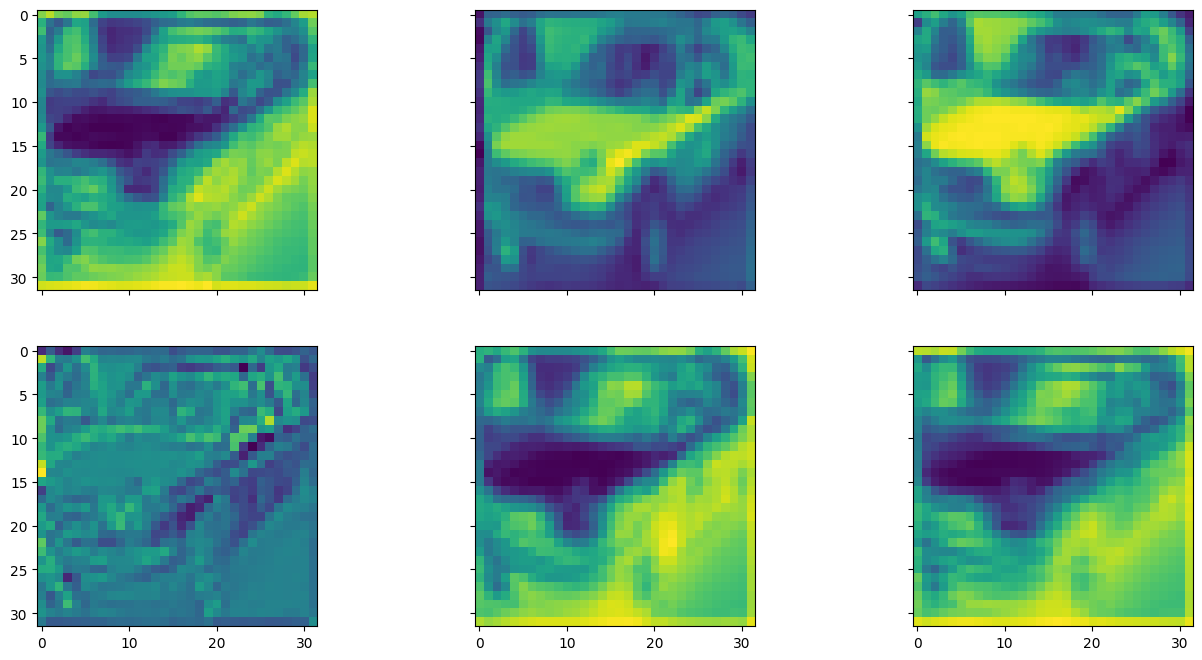

In [ ]:
# First, we convert the image of the car into batch with one image (because the network expects batches)
X = torch.tensor([trainset.data[60]], dtype=torch.float32).permute(0,3,1,2)
# Then we send it through conv1 to see what conv1 does.
with torch.no_grad(): # We don't actually need to compute gradients
    X = cnn.conv1(X)

# Plotting
cls = int(np.ceil(output_channels_1/2))
fig, axs = plt.subplots(2, cls, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, output_channels_1):
    row, col = i//cls, i%cls
    axs[row][col].imshow(X[0][i])
plt.show()

## Training

Having defined the architecture of the CNN, we set out to train it. To do so, we first need to decide what a good match to data implies (i.e., what the loss function is) and how to minimise the loss. Here, we settle for the cross entropy and stochastic gradient descent.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

We are now ready to train the network. We do so through successive forward and backpropagation, optimising the weights. For simplicity, let's settle for training during 5 epochs, although fixing the number of epochs in this manner is rather crude and not to be recommended. Running this cell might take a few minutes, which is also why we only have 5 epochs: 5 epochs will not be enough for convergence, *so you shouldn't do this if you were to build a CNN,* but since we are only trying to understand how things work in this notebook, it's good enough for our purposes (see also exercises 4 and 8). Below, we will see how we can speed up computations with GPUs.

epoch 1, loss: 2.219
epoch 2, loss: 1.803
epoch 3, loss: 1.614
epoch 4, loss: 1.488
epoch 5, loss: 1.386
Training time 104.34732031822205 seconds


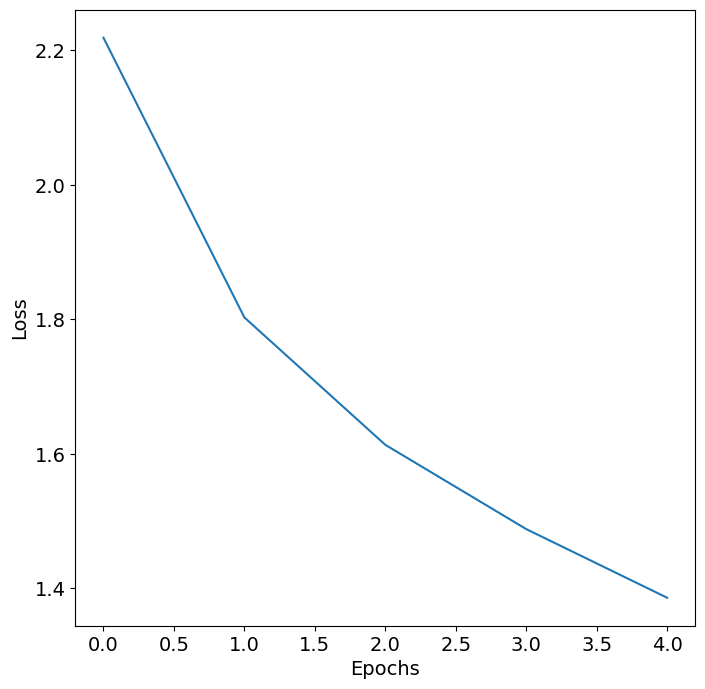

In [ ]:
n_epochs = 5
tloss = []
start = time.time()
batches = np.ceil(len(trainloader.dataset)/batch_size)

for epoch in range(n_epochs):

    training_loss = 0.0
    for  i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        y_pred = cnn(inputs) # Go through batches of training data
        loss = loss_func(y_pred, labels) # Compare output to truth

        optimizer.zero_grad()

        # backward + optimize
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        if i % batches == batches-1:    # print every 2000 mini-batches
            print(f'epoch {epoch + 1}, loss: {training_loss / batches:.3f}')
            tloss.extend([training_loss / batches])
            training_loss = 0.0

print("Training time {} seconds".format(time.time()-start))

plt.figure(figsize=(8,8))
plt.plot(tloss)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Before we continue, let's store the trained network.

In [ ]:
# On your own computer, you would do the following:
PATH = './cifar10_cnn.pth'
torch.save(cnn.state_dict(), PATH)
# That also works in google colab... but where did the file end up? And how can you store it on your Google cloud?

## Testing

We have successfully trained the network, but is it any good? Let's apply the network to the test data that we previously withheld to answer this question. For this purpose, let's start out by comparing some of the predicted labels with the ground truth.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = cnn(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))
print('Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

Predicted:  cat   car   ship  ship  frog  frog  car   frog  dog   car  
Truth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  


That doesn't look too bad. How does the model perform on the test set as a whole?

In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = cnn(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 52 %


If we were to guess randomly, the best we could do would be to get 10 per cent right with 10 categories. So, the model isn't doing that bad. But could we have done better? Should we have trained for longer than 20 epochs? What about overfitting? Or underfitting? We will answer these questions next notebook.

## Exercises

**Exercise 1**: Discuss what the different layers in the CNN (e.g., [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Explain the dimensions of the input and output of each layer.

**Exercise 2**: In the network above, one type of activation function is included. Which one? What other types of [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
) are there?


**Exercise 3**: Plot the output of the first pooling layer in the cell below. Rather than passing the images to this layer as done above (architecture, cell [7]), you will have to pass the output from conv1. Why?

**Exercise 4**: Explain what happens in the code in cell [9] (training). What does the plot show? Does it look like expected? What happens if you increase the number of epochs? See what happens to the accuracy of the network in cell [12] if you rerun the training with 20 epochs in cell [9].

**Exercise 5**: Copy the neural network into the cell below and change the architecture of the neural network introducing, e.g., dropout.

**Exercise 6**: Discuss the choice of the loss function. What alternatives are there?

**Exercise 7**: Having trained and tested your neural network, you get a yet unseen image and want to predict a label. What would you need to do with the image (transforms) to pass it to the network? (Hint: Also, note that the network expects batches). Since we are merely interested in learning how to make such predictions, let's just pretend that we had never seen one of the images from the test set before and wanted to make a prediction. Finish the code below.

In [ ]:
# Load and preprocess the new image
dummy = testset.data[1]
plt.imshow(dummy)

# Apply the transformation for the new image
# Remember to make the image into a batch. Check out transform(...).unsqueeze(0)

input_image = #[INSERT CODE HERE]

# Use evaluation mode (i.e. not training mode. This is important, e.g., when having dropout)
cnn.eval()

# Make and get prediction
with torch.no_grad():
    outputs = cnn(input_image)

_, predicted = outputs.max(1)

# Print the predicted class

print(#[INSERT CODE HERE])

# You can also get the probability of each class. What was the second most likely label?
probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

print(probabilities)

# Get the index of the second most likely label
#[INSERT CODE HERE]

SyntaxError: invalid syntax (<ipython-input-13-b17eb5dd9b2d>, line 8)

## GPUs

Running your code on GPUs rather than CPUs can significantly speed up the computations when training a neural network. Depending on your department, you will have different GPU resources available for high-performance computing (HPC). It is beyond this course to dive into HPC and batch scripts. Instead, we note that GPUs are available from other sources. Rather conveniently, Google Colab actually offers GPUs. To access these, select "Runtime" from the menu bar on the top. Then select "Change runtime type". Change from CPUs to GPUs. You can check the GPUs you have available with. See also [Google Colab's Guide](https://colab.research.google.com/notebooks/gpu.ipynb).

In [ ]:
!nvidia-smi

To actually run the code using GPUs, you need to add some additional lines of code to move the corresponding objects (the model and input tensors) to the GPUs, the device, defined as:

- device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This line of code checks whether a GPU with CUDA (Compute Unified Device Architecture) is available and sets device accordingly. We then move, e.g., the model to the device (either GPU or CPU) by running

- model = model.to(device)

The same is true for any PyTorch tensor

- tensor = tensor.to(device)

To get an idea of how exactly to change the code, you can compare notebook 2.1 with notebook 2.2.

**NB:** You cannot transform a tensor to numpy if it is on GPUs (see, e.g. [here](https://www.learnpytorch.io/00_pytorch_fundamentals/))

